# Analyzing (RE)PPTIS simulations using an MSM approach
This notebook contains an example workflow that can be used for estimating the crossing probability and pathlengths of a (RE)PPTIS simulation.

## 1. Import the necessary functions

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib qt

import matplotlib.pyplot as plt
from pprint import pprint    # to print the vars of the pathensemble object
import numpy as np
import os
import glob

# Reading
from tistools import read_inputfile, get_LMR_interfaces, read_pathensemble, get_weights
from tistools import set_tau_distrib, set_tau_first_hit_M_distrib, cross_dist_distr, pathlength_distr
from tistools import collect_tau, collect_tau1, collect_tau2, collect_taum
from tistools import ACCFLAGS, REJFLAGS

# REPPTIS analysis
from tistools import get_lmr_masks, get_generation_mask, get_flag_mask, select_with_masks
from tistools import unwrap_by_weight, running_avg_local_probs, get_local_probs, get_globall_probs, get_global_probz

# MSM functions
from tistools import construct_M
from tistools import global_cross_prob
from tistools import mfpt_to_first_last_state, construct_tau_vector
from tistools import create_labels_states, print_vector

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. Load the simulation data

In [32]:

# Set the working directory
indir = "/Users/an/Documents/0_mfpt/repptis1/"  

indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/simulations/sim_istarwell0_2108"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/simulations/sim_repptismazegap2708"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/i_star/simulations/RETIS_flat_br_noswap"

# zero_minus_one = True if lambda_-1 interface is set
# zero_minus_one = False if lambda_-1 interface is not set
zero_minus_one = False

inputfile = indir + "/repptis.rst"    # When using PyRETIS, the input file for REPPTIS simulations is a .rst file

# Move to working directory
os.chdir(indir)
print(os.getcwd())

# Set the ensemble folders and print them
folders = glob.glob(indir + "/0[0-9][0-9]")
folders = sorted(folders)
print(folders)

/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/simulations/sim_istarwell0_2108
['/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/simulations/sim_istarwell0_2108/000', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/simulations/sim_istarwell0_2108/001', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/simulations/sim_istarwell0_2108/002', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/simulations/sim_istarwell0_2108/003', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/simulations/sim_istarwell0_2108/004']


In [33]:
# Reading all input
#===================
interfaces, zero_left, timestep = read_inputfile(inputfile)
LMR_interfaces, LMR_strings = get_LMR_interfaces(interfaces, zero_left)
pathensembles = []
for i,fol in enumerate(folders):
    print("#"*80)
    print(fol)
    pe = read_pathensemble(fol+"/pathensemble.txt")
    pe.set_name(fol)
    pe.set_interfaces([LMR_interfaces[i], LMR_strings[i]])
    if i==0:
        pe.set_zero_minus_one(zero_minus_one)   # TODO this is never used
        pe.set_in_zero_minus(True)
    if i==1:
        pe.set_in_zero_plus(True)
    w, _ = get_weights(pe.flags, ACCFLAGS, REJFLAGS, verbose = False)
    pe.set_weights(w)
    print("pathensemble info: ")
    pprint(vars(pe))
    pathensembles.append(pe)

    
    # Read order parameters order.txt/order.npy into path ensemble object, or load from order.npy file.
    # Saving order parameter files allows to speed up this notebook.
    #### CHANGE HERE ####
    pe.set_orders(load=False, acc_only=True, save=True)        # for the 1st time you run this notebook for a certain simulation, this will store .npy files
    # pe.set_orders(load=True, acc_only=True)                  # for the next times, you can read npy files (save=True/False is not important)
    # pe.set_orders(load=False, acc_only=True, save=False)     # if saving doesn't work

################################################################################
/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/simulations/sim_istarwell0_2108/000
pathensemble info: 
{'cyclenumbers': array([    0,     1,     2, ..., 49998, 49999, 50000]),
 'flags': array(['ACC', 'ACC', 'ACC', ..., 'ACC', 'SWD', 'ACC'], dtype='<U3'),
 'generation': array(['ld', 'sh', 'sh', ..., 'sh', 's+', 'sh'], dtype='<U2'),
 'has_zero_minus_one': False,
 'in_zero_minus': True,
 'in_zero_plus': False,
 'interfaces': [[-0.35, -0.35, -0.35], ['l_[0]', 'l_[0]', 'l_[0]']],
 'lambmaxs': array([-0.3487675 , -0.34388951, -0.34248775, ..., -0.34436117,
       -0.34436117, -0.34378648]),
 'lambmins': array([-0.56983144, -0.5693401 , -0.59610072, ..., -0.55420724,
       -0.55420724, -0.52922641]),
 'lengths': array([119, 105,  90, ...,  95,  95,  95]),
 'lmrs': array(['RMR', 'RMR', 'RMR', ..., 'RMR', 'RMR', 'RMR'], dtype='<U3'),
 'name': '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3

## 3. Regular (RE)PPTIS analysis using tistools

### Analyze the REPPTIS simulation.

In [25]:
# Analysis output is saved to the data dictionary.
data = {}
for i, pe in enumerate(pathensembles):
    print("doing pathensemble {}".format(i))
    if i == 0:
        data[i] = {}
        continue  #  [0-] is not used for Pcross calculations

    # Classify the paths according to their path type.
    pathtypes = ("LML", "LMR", "RML", "RMR")
    pathtype_cycles = {}
    for ptype in pathtypes:
        pathtype_cycles[ptype] = unwrap_by_weight(
                (pe.lmrs == ptype).astype(int), pe.weights)
    
    # Running average analysis: ["running"]
    data[i] = {}
    data[i]["running"] = {}
    data[i]["running"]["plocal"] = {}
    for (ptype, p_loc) in zip(pathtypes, 
                              running_avg_local_probs(pathtype_cycles, 
                                                      pe.weights, tr = False)):
        data[i]["running"]["plocal"][ptype] = p_loc

    # Analysis using all data: ["full"]
    plocfull = get_local_probs(pe, tr=False)
    data[i]["full"] = {}
    for ptype in pathtypes:
        data[i]["full"][ptype] = plocfull[ptype]

    # data[i] have now ["full"] and ["running"]

doing pathensemble 0
doing pathensemble 1
Weights of the different paths:
wRMR = 0
wRML = 7869
wLMR = 8276
wLML = 83851
Local crossing probabilities:
pRMR = 0.0
pRML = 1.0
pLMR = 0.08983251381245455
pLML = 0.9101674861875455
Local crossing probabilities:
p2R = 0.0827633105324213
p2L = 0.9172366894675787
doing pathensemble 2
Weights of the different paths:
wRMR = 177
wRML = 4322
wLMR = 4251
wLML = 91246
Local crossing probabilities:
pRMR = 0.039342076016892644
pRML = 0.9606579239831073
pLMR = 0.04451448736609527
pLML = 0.9554855126339047
Local crossing probabilities:
p2R = 0.04428177127085083
p2L = 0.9557182287291491
doing pathensemble 3
Weights of the different paths:
wRMR = 15087
wRML = 13896
wLMR = 14073
wLML = 56940
Local crossing probabilities:
pRMR = 0.5205465272746093
pRML = 0.47945347272539074
pLMR = 0.19817498204554096
pLML = 0.801825017954459
Local crossing probabilities:
p2R = 0.29161166446657866
p2L = 0.7083883355334213
doing pathensemble 4
Weights of the different paths:
wR

/home/elias/anaconda3/envs/pastime/lib/python3.10/site-packages/tistools/repptis_analysis.py:555: RuntimeWarning: invalid value encountered in divide
  p_PP = cumsums['RMR']/(cumsums['RML']+cumsums['RMR'])
/home/elias/anaconda3/envs/pastime/lib/python3.10/site-packages/tistools/repptis_analysis.py:556: RuntimeWarning: invalid value encountered in divide
  p_PN = cumsums['RML']/(cumsums['RML']+cumsums['RMR'])


### Generate pathlength distribution figures, as in PyRETIS reports.

In [26]:
for i, pe in enumerate(pathensembles):
    upe = pe.unify_pe()
    # Pathlength distribution
    data[i]["pathlengths"] = pathlength_distr(upe)  # these might be used later or not! TODO
        
#=======================================
# make figures
makefigs = True 
if makefigs:
    for i, pe in enumerate(pathensembles):     
        if i == 0:
            continue
        # Cross distances distribution
        L, M, R, lmlpercs, lmllambs, rmrpercs, rmrlambs = cross_dist_distr(pe)
        fig,ax = plt.subplots()
        ax.plot(lmllambs, lmlpercs, lw=1, c="g")
        ax.plot(rmrlambs, rmrpercs, lw=1, c="r")
        for lamb in (L,M,R):
            ax.axvline(lamb, color='k', linestyle='--', lw = 0.5)
        ax.set_xlabel('Cross distance')
        ax.set_ylabel('Frequency')
        ax.set_title("Ensemble {}. L = {}, M = {}, R = {}".format(
            pe.name, L, M, R))
        ax.set_ylim(0)
        fig.savefig(f"pathensemble_{i}_crossdist.pdf")
        plt.close(fig)

        # Pathlength distribution      
        for ptype in pathtypes:
            fig, ax = plt.subplots()
            ax.plot(data[i]["pathlengths"][ptype]["bin_centers"], 
                data[i]["pathlengths"][ptype]["hist"])
            ax.set_xlabel('Pathlength')
            ax.set_ylabel('Frequency')
            ax.set_title(f"{np.sum(data[i]['pathlengths'][ptype]['hist'])} " + \
                         f"{ptype} paths. ")
            ax.legend([f"mean = {data[i]['pathlengths'][ptype]['mean']:.2f}, " + \
                          f"std = {data[i]['pathlengths'][ptype]['std']:.2f}"])
            fig.savefig(f"pathensemble_{i}_pathlength_{ptype}.pdf")
            plt.close(fig)

Are all weights 1?  True
Are all paths accepted?  True
Are all weights 1?  True
Are all paths accepted?  True
Are all weights 1?  True
Are all paths accepted?  True
Are all weights 1?  True
Are all paths accepted?  True
Are all weights 1?  True
Are all paths accepted?  True
Are all weights 1?  True
Are all paths accepted?  True


/home/elias/anaconda3/envs/pastime/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/elias/anaconda3/envs/pastime/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/elias/anaconda3/envs/pastime/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/elias/anaconda3/envs/pastime/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/elias/anaconda3/envs/pastime/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


### Compute Pcross using in-house functions

In [27]:
# Global crossing probabilities (no error analysis)  
psfull = []
for i in range(1, len(pathensembles)):   # do not use the 0- ensemble
    psfull.append({"LMR": data[i]["full"]["LMR"], 
               "RML": data[i]["full"]["RML"], 
               "RMR": data[i]["full"]["RMR"],
               "LML": data[i]["full"]["LML"]})

Pminfull, Pplusfull, Pcrossfull = get_globall_probs(psfull)

This should be the same as the repptis_report.pdf value: 0.00022509738028915336
which is the case!
[1.0, 0.08983251381245455, 0.003998848301169087, 0.000818284863374898, 0.0005233694222147923, 0.00022509738028915336]
[0.08983251381245455, 0.04451448736609527, 0.20463013391522442, 0.6395931852585303, 0.43009272367611256]
Here, the load immediately disappeared. For a simulation where this is
not the case, the above code should be adapted a little bit.


/tmp/ipykernel_674626/76830505.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


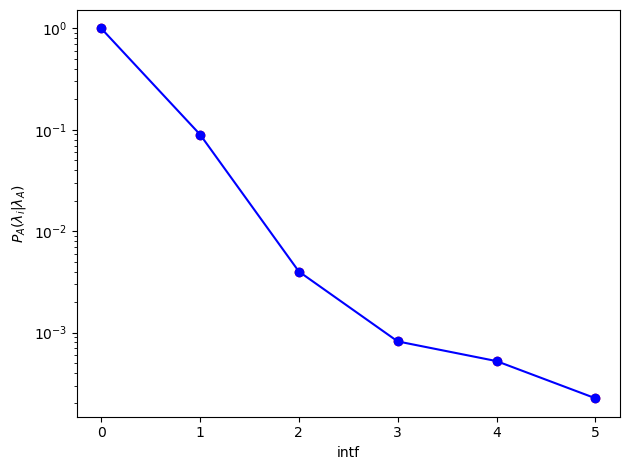

In [28]:
# Make a figure of the global crossing probabilities
fig, ax = plt.subplots()
ax.set_yscale("log")
ax.plot(Pcrossfull, "o", c = "r")
ax.errorbar([i for i in range(len(Pcrossfull))], Pcrossfull, fmt="-o", c = "b", ecolor="r", capsize=6)


ax.set_xlabel("intf")
ax.set_ylabel(r"$P_A(\lambda_i|\lambda_A)$")
ax.set_xticks(np.arange(len(interfaces)))
fig.tight_layout()
fig.show()
fig.savefig("Global_probs.pdf")

print("This should be the same as the repptis_report.pdf value:", Pcrossfull[-1])
print("which is the case!")
print(Pcrossfull)
print([Pcrossfull[i]/Pcrossfull[i-1] for i in range(1,len(Pcrossfull))])
print("Here, the load immediately disappeared. For a simulation where this is")
print("not the case, the above code should be adapted a little bit.")

In [ ]:
# TODO DONT INCLUDE??

# Construct lists of the local probs

# Or we can use the get_global_probz function, using lists of the local probs
# These do not use the 0- ensemble
pmps = [data[i]["full"]["LMR"] for i in range(1,len(pathensembles))]
pmms = [data[i]["full"]["LML"] for i in range(1,len(pathensembles))]
ppps = [data[i]["full"]["RMR"] for i in range(1,len(pathensembles))]
ppms = [data[i]["full"]["RML"] for i in range(1,len(pathensembles))]
a,b,c = get_global_probz(pmps, pmms, ppps, ppms)
print("This should be the same as the repptis_report.pdf value:", c[-1])

KeyError: 5

## 4. Analysis using the MSM

### Construct transition matrix M

In [78]:
print(interfaces)
N = len(interfaces)
NS = 4*N-5
print("N", N)
# print("len pmms", len(pmms)) # TODO INCLUDE?
print("NS", NS)

labels1, labels2 = create_labels_states(N)

[-0.35, -0.25, -0.12, 0.12, 0.25, 0.35]
N 6
len pmms 5
NS 19


In [79]:
print("mm", pmms)
print("mp", pmps)
print("pm", ppms)
print("pp", ppps)
print("sum", np.array(pmms)+np.array(pmps))
print("sum", np.array(ppms)+np.array(ppps))
if N > 3:  
    M = construct_M(pmms, pmps, ppms, ppps, N)
elif N == 3:
    M = construct_M_N3(pmms, pmps, ppms, ppps, N)
else:
    raise ValueError("The amount of interfaces needs to be 3 at least!")

mm [0.1761, 0.016558154489188973, 0.021047479197258932, 0.4185295340433017, 0.030242258944328575]
mp [0.8239, 0.983441845510811, 0.9789525208027411, 0.5814704659566984, 0.9697577410556715]
pm [nan, 0.9728083446134246, 0.5923196153481163, 0.9765082754938601, 0.9826073081219084]
pp [nan, 0.027191655386575364, 0.4076803846518837, 0.023491724506139882, 0.01739269187809159]
sum [1. 1. 1. 1. 1.]
sum [nan  1.  1.  1.  1.]


In [80]:
# We can print the transition matrix M and check that all rows sum to 1.
print("M")
print("shape", M.shape)
print("sum prob in rows", np.sum(M,axis=1))
print(M)

M
shape (19, 19)
sum prob in rows [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[0.         0.1761     0.8239     0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.01655815 0.98344185
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.         0.         0.
  0

### Look at this Markov model
*INCLUDE?*

In [81]:
#import numpy.linalg
vals, vecs = np.linalg.eig(M)
print(vals)
vals, vecs = np.linalg.eig(M.T)
print(vals)
pprint(M)

[ 1.00000000e+00+0.00000000e+00j  6.35365359e-01+6.64354935e-01j
  6.35365359e-01-6.64354935e-01j -1.49294171e-01+8.33130641e-01j
 -1.49294171e-01-8.33130641e-01j -7.72015418e-01+3.61648400e-01j
 -7.72015418e-01-3.61648400e-01j -4.98789360e-01+0.00000000e+00j
  3.53389090e-02+1.82639523e-01j  3.53389090e-02-1.82639523e-01j
 -1.11108283e-17+1.63367767e-08j -1.11108283e-17-1.63367767e-08j
 -3.18020432e-17+3.50405807e-17j -3.18020432e-17-3.50405807e-17j
  1.05842551e-17+7.17858998e-18j  1.05842551e-17-7.17858998e-18j
 -3.01685416e-32+0.00000000e+00j  1.16602115e-32+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j]
[ 1.00000000e+00+0.00000000e+00j  6.35365359e-01+6.64354935e-01j
  6.35365359e-01-6.64354935e-01j -1.49294171e-01+8.33130641e-01j
 -1.49294171e-01-8.33130641e-01j -7.72015418e-01+3.61648400e-01j
 -7.72015418e-01-3.61648400e-01j -4.98789360e-01+0.00000000e+00j
  3.53389090e-02+1.82639523e-01j  3.53389090e-02-1.82639523e-01j
  3.65263208e-16+1.39580638e-09j  3.65263208e-16-1.39580

In [82]:
print("what if chain propagates")
print("A[0,:]")
# check stationary behavior
A = M
for n in range(10):
    A = np.dot(A,M)
    #print(A)
    print(A[0,:])
    print(np.sum(A[0,:]))  # is 1 indeed

what if chain propagates
A[0,:]
[0.1761     0.         0.         0.         0.01364226 0.81025774
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
1.0
[0.         0.03101121 0.14508879 0.01364226 0.         0.
 0.         0.         0.01705388 0.79320385 0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
0.9999999999999999
[0.04465347 0.         0.         0.         0.0024024  0.14268639
 0.01659016 0.00046372 0.         0.         0.         0.
 0.33197924 0.46122461 0.         0.         0.         0.
 0.        ]
1.0
[0.         0.00786348 0.03679    0.01899256 0.         0.
 0.         0.         0.00301295 0.14013716 0.19663782 0.13534142
 0.         0.         0.         0.         0.01394847 0.44727614
 0.        ]
1.0
[2.68560388e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.09174451e-04 3.61808224e-02 1.94221930e-01 5.42883478e-03
 0.00000000e+00 0.00000

### Pcross with MSM

In [83]:
# Inspect Z and Y vectors

z1, z2, y1, y2 = global_cross_prob(M)
print("Z")
print_vector(z1, labels1)
print_vector(z2, labels2)
print("Y")
print_vector(y1, labels1)
print_vector(y2, labels2)
print("\nGlobal crossing probability: ", y1[0][0])

Z
state 0-      0
state B       1
state 0+- LML 0.0
state 0+- LMR 0.6665575095045514
state 0+- RML 0.0
state 1+- LML 0.0
state 1+- LMR 0.67778030042878
state 1+- RML 0.0
state 1+- RMR 0.67778030042878
state 2+- LML 0.018429968357068907
state 2+- LMR 0.6919563325683218
state 2+- RML 0.018429968357068907
state 2+- RMR 0.6919563325683218
state 3+- LML 0.2930134555918973
state 3+- LMR 0.9791065597705255
state 3+- RML 0.2930134555918973
state 3+- RMR 0.9791065597705255
state 4+- LML 0.30913096578082394
state 4+- LMR 1.0
Y
state 0-      0.5491767320807999
state B       0.0
state 0+- LML 0.0
state 0+- LMR 0.6665575095045514
state 0+- RML 0.0
state 1+- LML 0.0
state 1+- LMR 0.67778030042878
state 1+- RML 0.0
state 1+- RMR 0.67778030042878
state 2+- LML 0.018429968357068904
state 2+- LMR 0.6919563325683218
state 2+- RML 0.018429968357068904
state 2+- RMR 0.6919563325683218
state 3+- LML 0.2930134555918972
state 3+- LMR 0.9791065597705255
state 3+- RML 0.2930134555918972
state 3+- RMR 0.97910655

### Pathlength analysis

In [ ]:
# Setting path ensemble properties
#==================================
for i,fol in enumerate(folders):
    print(i)
    print("Calculating path lengths.")
    set_tau_distrib(pathensembles[i])
    print("Done.")

    if True:
        print("Calculating first hitting lengths to middle interface")
        set_tau_first_hit_M_distrib(pathensembles[i])
        print("Done.")

0
Calculating path lengths.


TypeError: 'NoneType' object is not subscriptable

In [85]:
# Compute taus for pathlength analysis
tau_mm, tau_mp, tau_pm, tau_pp = collect_tau(pathensembles)
tau1_mm, tau1_mp, tau1_pm, tau1_pp = collect_tau1(pathensembles)
tau2_mm, tau2_mp, tau2_pm, tau2_pp = collect_tau2(pathensembles)
taum_mm, taum_mp, taum_pm, taum_pp = collect_taum(pathensembles)

Collect tau
ensemble 0 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/simulations/sim_repptiswell2/000
ensemble 1 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/simulations/sim_repptiswell2/001
ensemble 2 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/simulations/sim_repptiswell2/002
ensemble 3 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/simulations/sim_repptiswell2/003
ensemble 4 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/simulations/sim_repptiswell2/004
ensemble 5 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/simulations/sim_repptiswell2/005
Collect tau1
Collect tau2
Collect taum


In [86]:
# Look at computed taus
print("tau")
print_all_tau(pathensembles, tau_mm, tau_mp, tau_pm, tau_pp)
print("\ntau1")
print_all_tau(pathensembles, tau1_mm, tau1_mp, tau1_pm, tau1_pp)
print("\ntaum")
print_all_tau(pathensembles, taum_mm, taum_mp, taum_pm, taum_pp)
print("\ntau2")
print_all_tau(pathensembles, tau2_mm, tau2_mp, tau2_pm, tau2_pp)

tau
                  mm            mp            pm            pp
0 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/simulations/sim_repptiswell2/000            nan           nan           nan         113.5
1 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/simulations/sim_repptiswell2/001           59.8          21.2           0.0           0.0
2 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/simulations/sim_repptiswell2/002          113.8          43.7          43.6         127.6
3 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/simulations/sim_repptiswell2/003          308.2          78.2          81.5         276.6
4 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/simulations/sim_repptiswell2/004          278.2          83.6          82.8         326.7
5 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/simulations/sim_repptiswell2/005          128.2          44.0          44.0         114.5

ta

In [88]:
# TODO include prints?
tau  = construct_tau_vector(N, NS, tau_mm, tau_mp, tau_pm, tau_pp)
tau1 = construct_tau_vector(N, NS, tau1_mm, tau1_mp, tau1_pm, tau1_pp)
taum = construct_tau_vector(N, NS, taum_mm, taum_mp, taum_pm, taum_pp)
tau2 = construct_tau_vector(N, NS, tau2_mm, tau2_mp, tau2_pm, tau2_pp)
tau_m = tau-tau1-tau2  # yes, this is the same thing as taum

# print("tau")
# print(tau)
# print("\n")
# print("tau1")
# print(tau1)
# print("taum")
# print(taum)
# print("tau2")
# print(tau2)

# print("\n")
# print("tau = tau1+taum+tau2 => difference is", np.sum((tau-tau1-taum-tau2)**2))

tau
[113.46279074  59.79136854  21.24126129   0.         113.77912621
  43.73040458  43.59641513 127.58565154 308.15245478  78.16376868
  81.52064085 276.63058659 278.2496753   83.55549445  82.79579005
 326.69545455 128.22015915  43.99160394   0.        ]


tau1
[ 0.          0.          0.          0.         43.79126214 20.67310993
 22.77246685 41.73645681 30.0620155  22.83284262 42.9529506  92.4062694
 90.90297196 43.03844462 23.01913614 32.34545455 40.97480106 22.83079659
  0.        ]
taum
[1.13462791e+02 5.97913685e+01 9.70968055e-05 0.00000000e+00
 2.57354369e+01 2.19207192e-01 2.11286626e-01 4.48140556e+01
 2.45488372e+02 1.36176879e+01 1.53774633e+01 9.59172098e+01
 9.22612117e+01 1.74638654e+01 1.70499180e+01 2.62581818e+02
 4.55981432e+01 3.33774506e-01 0.00000000e+00]
tau2
[ 0.          0.         21.24116419  0.         44.25242718 22.83808745
 20.61266165 41.03513909 32.60206718 41.71323815 23.19022697 88.30710739
 95.08549163 23.05318447 42.72673592 31.76818182 41.647214

## 5. Flux calculation

### Collect tau for [0+]

In [60]:
# Construct g and h vectors
g1, g2, h1, h2 = mfpt_to_first_last_state(M, tau1, tau_m, tau2) #, doprint=True)
print("G")
print_vector(g1, labels1)
print_vector(g2, labels2)
print("H")
print_vector(h1, labels1)
print_vector(h2, labels2)
print("\ntau [0+]: ", h1[0])

G
state 0-      0.0
state B       0.0
state 0+- LML 60.62462328384864
state 0+- LMR 297.7009799695676
state 0+- RML 0.0
state 1+- LML 72.60450819672131
state 1+- LMR 280.56746459879133
state 1+- RML 20.620395346028424
state 1+- RMR 349.80560703788194
state 2+- LML 504.40493525026807
state 2+- LMR 172.48383657783634
state 2+- RML 178.76002619446282
state 2+- RMR 510.76048359219766
state 3+- LML 355.8783859870806
state 3+- LMR 20.907583228067317
H
state 0-      255.2263799057542
state B       0.0
state 0+- LML 0.0
state 0+- LMR 297.7008825084302
state 0+- RML 0.0
state 1+- LML 42.70286885245902
state 1+- LMR 280.26064120668593
state 1+- RML 20.33612464269898
state 1+- RMR 304.126251254573
state 2+- LML 75.24979506335217
state 2+- LMR 65.45531553979151
state 2+- RML 64.52961097662684
state 2+- RMR 76.54315025886433
state 3+- LML 309.0842683400218
state 3+- LMR 20.610773807098326
interesting
[255.22637991]


### The flux

In [62]:
flux = 1/(tau[0]+h1[0][0])
dt = 0.0002 # Change if needed
flux
print(flux/dt, "1/time")

13.552717281537626 1/time


## 6. The rate constant
We can compute an accurate rate constant using only our MSM.

In [ ]:
# rate constant = flux * Pcross

print("The rate constant k is: ", flux*y1[0][0]/dt)